Installing *yt-dlp* to download the image frame from the YouTube videos, *pyarrow* in oreder to use .parquet files

In [1]:
!pip install yt-dlp
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing all the useful packages

In [2]:
import yt_dlp
import os
from tqdm.notebook import tqdm
import cv2
import shutil
import time
import random
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
from datetime import timedelta

In [3]:
# Importing drive to download or update datasets
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Setting Up Dataset


In [4]:
# Hyperparameters

percentage_train_test = 100
percentage_bag_shots = 1
percentage_to_ignore = 10

zip_f_name = f'VideoClassificationDataset_{percentage_train_test}_{percentage_bag_shots}_{percentage_to_ignore}' #VideoClassificationDataset
drive_dataset_folder = f'/content/drive/MyDrive/Datasets_VideoClassification/Multiclass/{zip_f_name}'

##Download frames

In [ ]:
dataset_path = Path('/content/VideoClassificationDataset')

# Download the .zip file
!wget --no-verbose https://github.com/gtoderici/sports-1m-dataset/archive/refs/heads/master.zip

# Extract it 
!unzip -qq -o '/content/master.zip' 
!rm '/content/master.zip

2023-04-21 10:00:42 URL:https://codeload.github.com/gtoderici/sports-1m-dataset/zip/refs/heads/master [150629222] -> "master.zip" [1]
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
DATA = {'train_partition.txt': {}, 'test_partition.txt': {}}

train_dict = {}
test_dict = {}

path = '/content/sports-1m-dataset-master/original'

# Choosen labels video
LABELS = {
    '398': 'rugby',
    '300': 'formula racing',
    '389': 'street football',
    '368': 'basketball',
    '338': 'hockey',
    '277': 'motocross',
    '283': 'trial',
    '269': 'motorcycle racing',
    '258': 'horse racing',
    '200': 'bodybuilding',
}

# Populate the DATA dictionary by reading the train and test files
for f in os.listdir(path):
    with open(path + '/' + f) as f_txt:
        lines = f_txt.readlines()
        for line in lines:
            splitted_line = line.split(' ')
            label_indices = splitted_line[1].rstrip('\n').split(',') 
            
            if(len(label_indices) == 1): # Skip in case the video has more than one label
                label = label_indices[0]
                if label in list(LABELS.keys()): # Skip in case the label is not one we want to consider
                    DATA[f][splitted_line[0]] = [int(label)] #list(map(int, label_indices))

In [ ]:
TRAIN = DATA['train_partition.txt']
TEST = DATA['test_partition.txt']
print('Original Train Test length: ', len(TRAIN), len(TEST))

# Sample a subset of percentage_train_test
TRAIN = dict(random.sample(list(TRAIN.items()), (len(TRAIN)*percentage_train_test)//100))
TEST = dict(random.sample(list(TEST.items()), (len(TEST)*percentage_train_test)//100))

print(f'Sampling {percentage_train_test} % of Train & Test datasets, updated length: ', len(TRAIN), len(TEST))

if not os.path.exists(dataset_path): os.makedirs(dataset_path)
if not os.path.exists(f'{dataset_path}/train'): os.makedirs(f'{dataset_path}/train')
if not os.path.exists(f'{dataset_path}/test'): os.makedirs(f'{dataset_path}/test')

Original Train Test length:  17643 4616
Sampling 100 % of Train & Test datasets, updated length:  17643 4616


In [ ]:
def extract_frames(capture, directory, idx_bag, start_frame, end_frame):
    '''
    PORPOUSE:
      Extract frames from a given youtube video

    TAKES:
      - capture: cv2.VideoCapture(url) variable, with url being the link to the video
      - directory: describe the saving directory
      - idx_bag: indicate the index of the actual bag of shots
      - start_frame: indicates the starting frame
      - end_frame: indicates the ending frame

    RETURNS:
      True or False depending the presence of errors
    '''

    count = start_frame

    # Set the next frame to download to 'count'
    capture.set(cv2.CAP_PROP_POS_FRAMES, count)
    os.makedirs(f'{directory}/bag_of_shots{str(idx_bag)}') # Create the relative directory

    # Download the frame until we do not reach the end_frame
    while count < end_frame:

        ret, frame = capture.read() # Read the frame

        if not ret or frame is None: # In case there are errors, delete the after mentioned directory of bag of shots
            shutil.rmtree(f'{directory}/bag_of_shots{str(idx_bag)}')
            return False

        # Save the readed frame in the directory of bag of shots resizing it to be 178x178
        filename = f'{directory}/bag_of_shots{str(idx_bag)}/shot{str(count - start_frame)}.png'
        write_res = cv2.imwrite(filename, cv2.resize(frame, (178, 178), interpolation = cv2.INTER_AREA))
        if write_res:
            count += 1    # If there is no error I increment the count
        else:   # Otherwise I delete the all bag of shots returning Falses
            shutil.rmtree(f'{directory}/bag_of_shots{str(idx_bag)}')
            return False

    return True

In [ ]:
def video_to_frames(video_url, label_id, directory, percentage_of_bags):
    '''
    PORPOUSE:
      Determine the amount of frame and bag of shots we want to downloads in each video, and perform the download of them

    TAKES:
      - video_url: complete url link to a specific YouTubbe video
      - directory: train or test string
      - label_id: label id
      - idx_bag: indicate the index of the actual bag of shots
      - percentage_of_bags: indicate the percentage of bags of shots that we want to download

    RETURNS: 
      ret_dictionary: A dictionary containing as keys the path to a specific bag of shots and as value the list of labels for the 
                      relative bag, the last element of this list represent the number of frames we have downloaded
    '''

    url_id = video_url.split('=')[1]
    path_until_url_id = f'{dataset_path}/{directory}/{url_id}'
    
    ret_dictionary = {}

    try:   

        # Setting up the dictionary options for yd-dlp
        ydl_opts = {
            'ignoreerrors': True,
            'quiet': True,
            'nowarnings': True,
            'ignorenoformatserror': True,
            'verbose': False,
            'cookies': '/content/all_cookies.txt', # Include all saved cookies to prevent the 'TOO MANY REQUESTS' error
            #https://stackoverflow.com/questions/63329412/how-can-i-solve-this-youtube-dl-429
        }

        ydl = yt_dlp.YoutubeDL(ydl_opts)
        info_dict = ydl.extract_info(video_url, download=False) # Extracting the video infromation
        
        if(info_dict is not None):

            formats = info_dict.get('formats', None)

            format_id = {}
            for f in formats: format_id[f['format_id']] = f

            # I only consider the format_id 160 with indicates the 144p resolution
            if '160' in list(format_id.keys()): 
                
                video = format_id['160'] # Get all the details of the 144p resolution video
                fps = video.get('fps', None)
                url = video.get('url', None)

                # I must have a least 20 frames per seconds since I take half of second bag of shots for every video
                if(fps >= 20 and url != video.get('manifest_url', None)):
                    
                    capture = cv2.VideoCapture(url) # Initialize VideoCapture variable
                    video_length = int(capture.get(cv2.CAP_PROP_FRAME_COUNT)) # Get the total frame count
                    shots = fps // 2

                    # Excluding the initial and final choosen percentage of each video to avoid noise
                    to_ignore = (video_length * percentage_to_ignore) // 100
                    new_len = video_length - (to_ignore * 2)
                    tot_stored_bags = ((new_len // shots) * percentage_of_bags) // 100   # ((total_possbile_bags // shots) * percentage_of_bags) // 100

                    if tot_stored_bags == 0: tot_stored_bags = 1 # I take at least a bag of shots

                    # Computing the skip rate between bags
                    skip_rate_between_bags = (new_len - (tot_stored_bags * shots)) // (tot_stored_bags + 1)

                    chunks = [[to_ignore + ((bag * skip_rate_between_bags) + (shots * (bag - 1))),
                              to_ignore + (bag * (skip_rate_between_bags + shots))] for bag in range(1, tot_stored_bags + 1)]
                    # Sequence of [[start_frame, end_frame], [start_frame, end_frame], [start_frame, end_frame], ...]

                    if not os.path.exists(path_until_url_id): os.makedirs(path_until_url_id)
                    # Create the the folder that will contain all the bag of shots

                    capture = cv2.VideoCapture(url) # Initialize VideoCapture variable
                    valid_chunks = 0
 
                    for idx_bag, f in enumerate(chunks): # For each chunks

                        # In case the download of the bag of shots succedeed
                        if(extract_frames(capture, path_until_url_id, idx_bag, f[0], f[1])):
                              
                              l = np.array([label_id, shots], dtype=object)
                              valid_chunks += 1

                              ret_dictionary[f'{directory}/{url_id}/bag_of_shots{str(idx_bag)}'] = l.tolist() # Populate the new dictionary row

                    # In case we do not have downloaded any chunks delete the directory and all its content
                    if valid_chunks == 0: shutil.rmtree(path_until_url_id)

                    capture.release()

        return ret_dictionary


    except Exception as e:
        # If an exception rised delete the directory with all its content and return ret_dictionary
        if os.path.exists(path_until_url_id): shutil.rmtree(path_until_url_id)
        return ret_dictionary


In [ ]:
start_time = time.time()

count = 0

# Perform a parallel download
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as pool:
    with tqdm(total = len(TRAIN.items()), leave=False, desc='Downloading Train Dataset') as progress: # Setting up the progress bar
        
        futures = [] # Array of features

        for url, label_id in TRAIN.items():
            future = pool.submit(video_to_frames, url, label_id, 'train', percentage_bag_shots) # Assign the download
            future.add_done_callback(lambda p: progress.update()) # Update the progrress bar
            futures.append(future) # Append the feature to the features array

        for future in futures:
            if len(future.result()) > 0: # In case the result of the featue is not empty
                train_dict.update(future.result()) # Append the result to the final dictionaty
                count += 1


print(f'--- Downloaded {count} videos frames in {(timedelta(seconds=(time.time() - start_time)))} (H:M:S:ms) ---')

In [ ]:
start_time = time.time()

count = 0

# Perform a parallel download
with ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()) as pool:
    with tqdm(total = len(TEST.items()), leave=False, desc='Downloading Test Dataset') as progress: # Setting up the progress bar
        
        futures = [] # Array of features

        for url, label_id in TEST.items():
            future = pool.submit(video_to_frames, url, label_id, 'test', percentage_bag_shots) # Assign the download
            future.add_done_callback(lambda p: progress.update()) # Update the progrress bar
            futures.append(future) # Append the feature to the features array

        for future in futures:
            if len(future.result()) > 0: # In case the result of the featue is not empty
                test_dict.update(future.result()) # Append the result to the final dictionaty
                count += 1


print(f'--- Downloaded {count} videos frames in {(timedelta(seconds=(time.time() - start_time)))} (H:M:S:ms) ---')

## Save CSV and upload file Zip

In [ ]:
# Convert the dictionary to pandas DataFrame resetting the index
train_df = pd.DataFrame.from_dict(train_dict, orient='index', dtype=int).reset_index(level=0)
col_train = {val: list(LABELS.keys())[idx] for idx in train_df.columns[1:-1]}
col_train[10] = 'shots'
train_df = train_df.rename(columns=col_train) # Rename the last column as 'shots'
train_df.columns = train_df.columns.astype(str) # Setting the column type as string
train_df.to_parquet(f'{dataset_path}/train.parquet', index=True) # Generation the parquet file

# Convert the dictionary to pandas DataFrame resetting the index
test_df = pd.DataFrame.from_dict(test_dict, orient='index', dtype=int).reset_index(level=0)
col_test = {val: list(LABELS.keys())[idx] for idx in test_df.columns[1:-1]}
col_test[10] = 'shots'
test_df = test_df.rename(columns=col_test) # Rename the last column as 'shots'
test_df.columns = test_df.columns.astype(str) # Setting the column type as string
test_df.to_parquet(f'{dataset_path}/test.parquet', index=True) # Generation the parquet file

with open(f'{dataset_path}/labels.csv', 'w') as f: # Writing a csv file for the labels
    for key in LABELS.keys():
        f.write("%s,%s\n" % (key, LABELS[key]))

In [ ]:
shutil.make_archive('train', 'zip', f'{dataset_path}/train') # Create a train.zip file
shutil.make_archive('test', 'zip', f'{dataset_path}/test') # Create a test.zip file
os.mkdir(drive_dataset_folder) # Create remote drive folder

# Coping the .zip, .parquet and .csv file into the remote directory
shutil.copy(f'{dataset_path}/train.parquet', drive_dataset_folder)
shutil.copy(f'{dataset_path}/test.parquet', drive_dataset_folder)
shutil.copy(f'{dataset_path}/labels.csv', drive_dataset_folder)
shutil.copy('/content/train.zip', drive_dataset_folder)
shutil.copy('/content/test.zip', drive_dataset_folder)

## Download Dataset from Google Drive

In [5]:
# With ZipFile I also download the .zip and at the same time unzipping it so I need the double capacity

dataset_path = Path('/content/VideoClassificationDataset')


# Unzip the train and test zip files in Colab Storage
for z in ['train', 'test']:
    with zipfile.ZipFile(f'{drive_dataset_folder}/{z}.zip', 'r') as zip_ref:
        for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist()), desc=f'Unzipping {z}.zip'):
            zip_ref.extract(member=file, path=dataset_path)

# Copy the train and test .parquet and labels.txt in Colab Storage
shutil.copy(f'{drive_dataset_folder}/train.parquet', dataset_path)
shutil.copy(f'{drive_dataset_folder}/test.parquet', dataset_path)
shutil.copy(f'{drive_dataset_folder}/labels.csv', dataset_path)


print('All done')

Unzipping train.zip:   0%|          | 0/274055 [00:00<?, ?it/s]

Unzipping test.zip:   0%|          | 0/59111 [00:00<?, ?it/s]

All done


### Read labels.csv, train.parquet and test.parquet

In [6]:
train_dict = {}
test_dict = {}
LABELS = {}

train_df = pd.read_parquet(f'{dataset_path}/train.parquet') # Read the parquet train dataset
test_df = pd.read_parquet(f'{dataset_path}/test.parquet') # Read the parquet test dataset


for string, df, dic in zip(('train', 'test'), (train_df, test_df), (train_dict, test_dict)):
    for k,v in tqdm(df.T.items(), total=len(list(df.T.items())), desc=f'Populating {string} dictionary'):
        values = v.to_numpy()
        dic[values[0]] = list(values[1:]) # Populate the dictionary

with open(f'{dataset_path}/labels.csv', 'r') as label_csv: # Read the labels and create a dictionary
    lines = label_csv.readlines()
    for line in tqdm(lines, total=len(lines), desc=f'Populating the LABELS dictionary'):
        splitted_line = line.split(',')
        LABELS[splitted_line[0]] = splitted_line[1]


print(f'\nSampled {percentage_train_test} % of Train & Test datasets')
print(f'Number of train bags of shots: {len(train_df)}')
print(f'Number of test bags of shots: {len(test_dict)}')
print(f'Number of labels: {len(LABELS)}')

Populating train dictionary:   0%|          | 0/18287 [00:00<?, ?it/s]

Populating test dictionary:   0%|          | 0/3868 [00:00<?, ?it/s]

Populating the LABELS dictionary:   0%|          | 0/10 [00:00<?, ?it/s]


Sampled 100 % of Train & Test datasets
Number of train bags of shots: 18287
Number of test bags of shots: 3868
Number of labels: 10


### Data Consistency Checking

In [7]:
# Check the presence of empty or inconsistent directories

print(train_df[train_df['shots'] < 5][['index', 'shots']])
print(test_df[test_df['shots'] < 5][['index', 'shots']])

for idx, row in train_df[train_df['shots'] < 5].iterrows():
    print(row['index'], os.listdir(f"{dataset_path}/{row['index']}"))

for idx, row in test_df[test_df['shots'] < 5].iterrows():
    print(row['index'], os.listdir(f"{dataset_path}/{row['index']}"))

to_del_train = []
for idx, row in train_df.iterrows():
    for shot_id in range(row['shots']):
        if f'shot{shot_id}.png' not in os.listdir(f"{dataset_path}/{row['index']}"):
            print(row['index'], os.listdir(f"{dataset_path}/{row['index']}"))
            to_del_train.append(idx)
            break

to_del_test = []
for idx, row in test_df.iterrows():
    for shot_id in range(row['shots']):
        if f'shot{shot_id}.png' not in os.listdir(f"{dataset_path}/{row['index']}"):
            print(row['index'], os.listdir(f"{dataset_path}/{row['index']}"))
            to_del_test.append(idx)
            break


Empty DataFrame
Columns: [index, shots]
Index: []
Empty DataFrame
Columns: [index, shots]
Index: []


In [8]:
# Throw away those directory with correspondant row of dictionary and dataframe

to_delete_train = train_df[train_df['shots'] < 5]
to_delete_train = pd.concat([to_delete_train, train_df.iloc[to_del_train]], axis=0)
train_df.drop(to_delete_train.index, axis=0, inplace=True)
train_df.reset_index()

for idx, to_d in to_delete_train.iterrows():
    del train_dict[to_d['index']]
    shutil.rmtree(f"{dataset_path}/{to_d['index']}")


to_delete_test = test_df[test_df['shots'] < 5]
to_delete_test = pd.concat([to_delete_test, test_df.iloc[to_del_test]], axis=0)
test_df.drop(to_delete_test.index, axis=0, inplace=True)
test_df.reset_index()

for idx, to_d in to_delete_test.iterrows():
    del test_dict[to_d['index']]
    shutil.rmtree(f"{dataset_path}/{to_d['index']}")

# Neural Networks Part

In [9]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.8 MB/s eta 0:00:00


In [10]:
import requests
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from timeit import default_timer as timer 
import copy

from google.colab import widgets

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

from torchmetrics.classification import MulticlassAccuracy

torch.autograd.set_detect_anomaly(True)

print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')


PyTorch version: 2.0.0+cu118
torchvision version: 0.15.1+cu118


In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Setup the device type
print(f'Running application on {device}') 

Running application on cuda:0


In [12]:
# Get the train and test path
train_dir = dataset_path / 'train'
test_dir = dataset_path / 'test'

## Initial analysis

In [13]:
def get_label_id_name(label_id):
    '''
    PORPOUSE:
      Get the label id and name of a particular frame

    TAKES:
      - label_id: label index (from 0 to 9)

    RETURNS: 
      Actual label id and label name
    '''
    ids_str = list(LABELS.keys())[label_id]
    return int(ids_str), LABELS[ids_str]

Transforms

In [14]:
# Setting up the train and test transofms

train_transform = transforms.Compose([
    #transforms.Resize((178, 178)), # ---> VEDO SE METTENDO QUESTO E TOGLIENDO DAL DPWNOAD IL RESIZE L'IMMAGINE MGLIORA

    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4588,0.4588,0.4588], std=[0.4588,0.4588,0.4588])
])

test_transform = transforms.Compose([
    #transforms.Resize((178, 178)),

    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.4588,0.4588,0.4588], std=[0.4588,0.4588,0.4588])
])

## From Dataset to Dataloader

Dataset creation

In [15]:
# VideoDataset object 

class VideoDataset(Dataset):
    def __init__(self, df, transform = None, t = 'single'):
        self.df = df
        self.transform = transform
        self.t = t
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        if self.transform is None: self.transform = transforms.ToTensor()
        images_path = self.df.iloc[index, 0]

        shots = self.df.iloc[index, -1] # Get the number of frames of a bag of shots
        # Each bag is half second frames

        if self.t == 'single':
            # I want only the central frame
            images = self.transform(Image.open(f'{dataset_path}/{images_path}/shot{shots//2}.png'))

        if self.t == 'early':
            # I want the 5 middle frames
            images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot{idx}.png')).numpy() for idx in range((shots//2)-2,(shots//2)+3)])
        
        if self.t == 'late':
            # I want the first and last frames
            images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot0.png')).numpy(), self.transform(Image.open(f'{dataset_path}/{images_path}/shot{shots-1}.png')).numpy()])
        
        if self.t == 'slow':
            # I want the 10 middle frames
            if shots%10 == 0:
                images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot{idx}.png')).numpy() for idx in range((shots//2) - 5, (shots//2) + 5)])
            else:
                images = np.array([self.transform(Image.open(f'{dataset_path}/{images_path}/shot{idx}.png')).numpy() for idx in range((shots%10) - (shots%10)//2, shots-(shots%10)//2)])

        y_label = torch.tensor(np.where(self.df.iloc[index, 1:-1].to_numpy().astype(float) == 1.)[0][0]) # tensor with the corresponding label index (from 0 to 9)

        if self.t != 'single': images = torch.from_numpy(images) # Convert the numpy image to tensor in case I want the central frame

        return images, y_label, images_path

Split the training set into train and validation set

In [16]:
def spit_train(train_data, perc_val_size):
    '''
    PORPOUSE: 
      Split the dataset in train and validation set

    TAKES:
      - train_data: dataset to split
      - perc_val_size: percentage of split

    RETURNS: 
      Train dataset and validation dataset
    '''
    
    train_size = len(train_data)
    val_size = int((train_size * perc_val_size) // 100)
    train_size -= val_size

    return random_split(train_data, [int(train_size), int(val_size)]) #train_data, val_data 

Dataset definition

In [17]:
# Let's set the validations set to the 20% of the train dataset

# Dataset for Single Frame
train_data_single, val_data_single = spit_train(VideoDataset(df=train_df, transform=train_transform, t='single'), 20)
test_data_single = VideoDataset(df=test_df, transform=test_transform, t='single')

# Dataset for Multi Frame - Early Fusion
train_data_early, val_data_early = spit_train(VideoDataset(df=train_df, transform=train_transform, t='early'), 20)
test_data_early = VideoDataset(df=test_df, transform=test_transform, t='early')

# Dataset for Multi Frame - Late Fusion
train_data_late, val_data_late = spit_train(VideoDataset(df=train_df, transform=train_transform, t='late'), 20)
test_data_late = VideoDataset(df=test_df, transform=test_transform, t='late')

# Dataset for Multi Frame - Slow Fusion
train_data_slow, val_data_slow = spit_train(VideoDataset(df=train_df, transform=train_transform, t='slow'), 20)
test_data_slow = VideoDataset(df=test_df, transform=test_transform, t='slow')

### Random Image from the train and test dataloader for Single Frame model

In [18]:
def random_image_from_dataloader(dt, dic):
    '''
    PORPOUSE:
      Plot a random image from a given dataset

    TAKES:
      - dt: dataset where sample a image
      - dic: dictionary to which the image belongs

    RETURNS: 
      None
    '''
    
    rnd = random.choice(dt)
    img, label, path = rnd
    label_id, label_names = get_label_id_name(label)

    print(f'Image tensor:\n{img}')
    print(f'Image shape: {img.shape}')
    print(f'Image datatype: {img.dtype}')
    print(f'Image label ids: {label_id}')
    print(f'Image label names: {label_names}')
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis(False)

Image tensor:
tensor([[[0.5725, 0.6510, 0.6863,  ..., 0.8157, 0.8118, 0.7804],
         [0.5922, 0.6667, 0.6980,  ..., 0.8627, 0.8588, 0.8235],
         [0.5882, 0.6627, 0.6941,  ..., 0.8863, 0.8824, 0.8471],
         ...,
         [0.2667, 0.2863, 0.3059,  ..., 0.0706, 0.0706, 0.0706],
         [0.2510, 0.2627, 0.2627,  ..., 0.0706, 0.0706, 0.0706],
         [0.2392, 0.2314, 0.2157,  ..., 0.0706, 0.0706, 0.0706]],

        [[0.5451, 0.6235, 0.6549,  ..., 0.7686, 0.7647, 0.7333],
         [0.5647, 0.6392, 0.6667,  ..., 0.8157, 0.8118, 0.7765],
         [0.5608, 0.6314, 0.6627,  ..., 0.8196, 0.8157, 0.7804],
         ...,
         [0.2588, 0.2784, 0.2941,  ..., 0.0510, 0.0510, 0.0510],
         [0.2431, 0.2549, 0.2510,  ..., 0.0510, 0.0510, 0.0510],
         [0.2314, 0.2235, 0.2039,  ..., 0.0510, 0.0510, 0.0510]],

        [[0.4235, 0.5059, 0.5608,  ..., 0.6667, 0.6627, 0.6314],
         [0.4431, 0.5216, 0.5725,  ..., 0.7137, 0.7059, 0.6745],
         [0.4392, 0.5137, 0.5686,  ..., 0.69

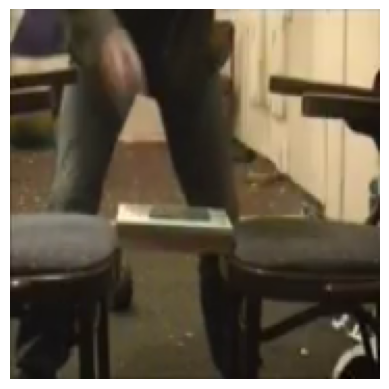

In [19]:
random_image_from_dataloader(train_data_single, train_dict) # Random image from the train dataset

Image tensor:
tensor([[[0.0471, 0.3765, 0.4824,  ..., 0.4667, 0.4353, 0.4000],
         [0.0471, 0.3765, 0.4745,  ..., 0.4667, 0.4118, 0.3373],
         [0.0510, 0.3725, 0.4745,  ..., 0.4627, 0.4157, 0.3647],
         ...,
         [0.0314, 0.3333, 0.3843,  ..., 0.4627, 0.4471, 0.3843],
         [0.0275, 0.3490, 0.4275,  ..., 0.4784, 0.4510, 0.3412],
         [0.0235, 0.3608, 0.4784,  ..., 0.4784, 0.4118, 0.2431]],

        [[0.0471, 0.3765, 0.4824,  ..., 0.4745, 0.4549, 0.4196],
         [0.0471, 0.3765, 0.4745,  ..., 0.4745, 0.4314, 0.3529],
         [0.0510, 0.3725, 0.4745,  ..., 0.4706, 0.4353, 0.3804],
         ...,
         [0.0667, 0.3686, 0.4196,  ..., 0.4824, 0.4588, 0.3961],
         [0.0627, 0.3804, 0.4627,  ..., 0.4980, 0.4627, 0.3529],
         [0.0588, 0.3961, 0.5137,  ..., 0.4980, 0.4235, 0.2549]],

        [[0.0118, 0.2078, 0.3137,  ..., 0.2941, 0.2784, 0.2431],
         [0.0118, 0.2078, 0.3059,  ..., 0.2941, 0.2549, 0.1804],
         [0.0118, 0.2078, 0.3059,  ..., 0.29

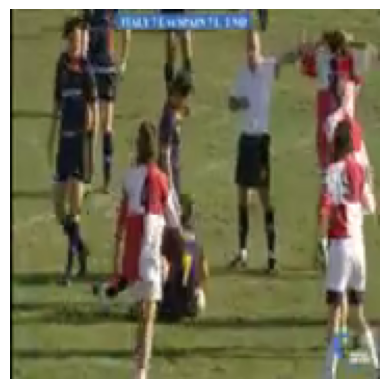

In [20]:
random_image_from_dataloader(test_data_single, test_dict) # Random image from the test dataset


### Turn loaded images into DataLoader's

In [43]:
# Turn train and test satasets into DataLoaders
BATCH_SIZE = 32 # <---------------------------- TODO: tune this paramenter
NUM_WORKERS = os.cpu_count()

In [44]:
def generate_dataloaders(train_data, val_data, test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    '''
    PORPOUSE:
      Generate the train vaiadtion and test dataloaders

    TAKES:
      - train_data: train dataset
      - val_data: validation dataset
      - test_data: test dataset
      - batch_size: specify how many bags of shots a bach must have
      - num_workers: specify how many workers will work on the dataloaders creation 

    RETURNS: 
      train, val and test dataloaders
    '''
    
    train_dl = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
    val_dl = DataLoader(dataset = val_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
    test_dl = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)

    return train_dl, val_dl, test_dl

## Models definitions

In [45]:
# Defining the main custom Alexnet that ereditate the fucntion of nn.Module

class AlexNet(nn.Module):
    def __init__(self, in_channels, stream_type=None, t_frames=[1,1,1]):
        # stream_type: none, "context", "fovea"
        # None is used for considering the cnn with spartial fusion informations
        super().__init__()

        # input size nomultiresulution : (b x 3 x 170 x 170)
        # input size multiresulution : (b x 3 x 178 x 178) take into account the video classifier -> which becomes 89 x 89 in both streams

        self.stream_type = stream_type
        self.fovea = transforms.Compose([transforms.CenterCrop((89, 89))])
        self.context = transforms.Compose([transforms.Resize((89, 89))])
        self.transform = transforms.Compose([transforms.Resize((170, 170))])
        self.t_frames = t_frames

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels*self.t_frames[0], 96, kernel_size=11, stride=3, padding=2),  
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 170 x 170) -> (b x 96 x 55 x 55)
            # MULTIRES -> in: (b x 96 x 89 x 89) -> (b x 96 x 28 x 28)
            nn.ReLU(inplace=True),

            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 55 x 55) -> (b x 96 x 28 x 28)
            # MULTIRES -> in: (b x 96 x 28 x 28) -> (b x 96 x 14 x 14)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(96*self.t_frames[1], 256, kernel_size=5, stride=1, padding=2), 
            # CORRECT
            # NO-MULTIRES -> in: (b x 96 x 28 x 28) -> (b x 256 x 28 x 28)
            # MULTIRES -> in: (b x 96 x 14 x 14) -> (b x 256 x 14 x 14)
            nn.ReLU(inplace=True),

            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.5, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            # CORRECT
            # NO-MULTIRES -> in: (b x 256 x 28 x 28) -> (b x 256 x 14 x 14)
            # MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 256 x 7 x 7)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(256*self.t_frames[2], 384, kernel_size=3, stride=1, padding=1), 
            # CORRECT
            # NO-MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 384 x 14 x 14)
            # MULTIRES -> in: (b x 256 x 7 x 7) -> (b x 384 x 7 x 7)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            # CORRECT
            # NO-MULTIRES -> in: (b x 384 x 14 x 14) -> (b x 384 x 14 x 14)
            # MULTIRES -> in: (b x 384 x 7 x 7) -> (b x 384 x 7 x 7)
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            # CORRECT
            # NO-MULTIRES -> in: (b x 384 x 14 x 14) -> (b x 256 x 14 x 14)
            # MULTIRES -> in: (b x 384 x 7 x 7) -> (b x 256 x 7 x 7)
            nn.ReLU(inplace=True)
        )

        self.MaxPool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # CORRECT
        # NO-MULTIRES -> in: (b x 256 x 14 x 14) -> (b x 256 x 7 x 7)


    def forward(self, x):
        if self.stream_type != None:
            x = self.fovea(x) if self.stream_type == 'fovea' else self.context(x)
            return self.conv3(self.conv2(self.conv1(x)))
        else: 
            x = self.transform(x)
            return self.MaxPool(self.conv3(self.conv2(self.conv1(x))))

### Single frame CNNs:
1. Single-Fame (custom AlexNet)
2. Single-Fame Fovea Only
3. Single-Fame Context Only
4. Single-Fame + Multiresolution



In [46]:
# The single frame CNN, includes the three CNNs from the above list

class SingleResCNN(nn.Module):
    def __init__(self, CNN, num_classes):
        super(SingleResCNN, self).__init__()
        self.CNN = CNN

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

        
    def forward(self, x):
        x = self.CNN(x)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [47]:
# Defining the single frame multiresolution CNN 

class MultiResCNN(nn.Module):
    def __init__(self, AlexNet_fovea, AlexNet_context, num_classes):
        super(MultiResCNN, self).__init__()
        self.AlexNet_fovea = AlexNet_fovea
        self.AlexNet_context = AlexNet_context

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(512 * 7 * 7), out_features=4096), # 512 since it takes the double of the infrormations
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        x1 = self.AlexNet_fovea(x.clone().detach()) # Takes the fovea strea
        x2 = self.AlexNet_context(x.clone().detach()) # Takes the contxt stream
        x = torch.cat((x1, x2), dim=1)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

### Multi Frames CNNs
1. Late Fusion
2. Early Fusion
3. Slow Fusion

In [79]:
# Late Fusion Model

class LateFusionCNN(nn.Module):
    def __init__(self, AlexNet_1, AlexNet_2, num_classes):
        super(LateFusionCNN, self).__init__()
        self.AlexNet_1 = AlexNet_1 # Two Separates AlexNet
        self.AlexNet_2 = AlexNet_2

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(512 * 7 * 7), out_features=4096),  # 512 since it takes the double of the infrormations
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        initial = torch.empty(x.shape[0], 3, 178, 178).to(device)
        final = torch.empty(x.shape[0], 3, 178, 178).to(device)
        
        for i in range(x.shape[0]):
            initial[i] = x[i][0]
            final[i] = x[i][1]

        initial = self.AlexNet_1(initial)
        final = self.AlexNet_2(final)
        x = torch.cat((initial, final), dim=1)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [80]:
# Early Fusion Model

class EarlyFusionCNN(nn.Module):
    def __init__(self, AlexNet, num_classes):
        super(EarlyFusionCNN, self).__init__()
        self.AlexNet = AlexNet

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[1]*3, 178, 178)
        x = self.AlexNet(x)
        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

In [81]:
# Sow Fusion Model

class SlowFusionCNN(nn.Module):
    def __init__(self, AlexNet, num_classes):
        super(SlowFusionCNN, self).__init__()
        self.AlexNet = AlexNet

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 7 * 7), out_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        
    def forward(self, x):
        bag = torch.empty(4,x.shape[0],3*self.AlexNet.t_frames[0],178,178).to(device)
        
        for idx in range(bag.shape[0]): # 0 - 4
            for i in range(x.shape[0]): # 0 - batch_size
                bag[idx][i] = x[i][(idx) : (idx+4)].reshape(3*self.AlexNet.t_frames[0],178,178)

        rconv2_2 = torch.cat((self.AlexNet.conv2( # Second layer
            torch.cat((self.AlexNet.conv1(bag[0]), self.AlexNet.conv1(bag[1])), dim=1) # First layer
        ), self.AlexNet.conv2( # Second layer
            torch.cat((self.AlexNet.conv1(bag[2]), self.AlexNet.conv1(bag[3])), dim=1) # First layer
        )), dim=1)

        x = self.AlexNet.MaxPool(self.AlexNet.conv3(rconv2_2)) # Third layer

        x = x.reshape(x.shape[0], -1)
        return self.classifier(x)

### Train and Evaluate Architecture

In [134]:
# CNN Architecture to perform the Train and Evaluation steps saving the results

class CNN_Architecture():

    def __init__(self, model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
        val_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module, score_fn, scheduler: torch.optim.Optimizer, device: torch.device,
        patience = None, save_check = False, load_check_train = False, load_check_evaluate = False):

        self.model = model.to(device)
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.loss_fn = loss_fn
        self.val_dataloader = val_dataloader
        self.score_fn = score_fn
        self.scheduler = scheduler
        self.device = device
        self.save_check = save_check
        self.load_check_train = load_check_train
        self.load_check_evaluate = load_check_evaluate
        self.patience = patience
        if self.model.__class__.__name__ == 'SingleResCNN':
            self.model_name = f'{self.model.__class__.__name__}-Stream_Type_{self.model.CNN.stream_type}'
        else: 
            self.model_name = self.model.__class__.__name__
        self.best_checkpoint_filename = f'/content/drive/MyDrive/checkpoints/multiclass/best_checkpoints/{self.model_name}_checkpoint.pth.tar'
        self.last_checkpoint_filename = f'/content/drive/MyDrive/checkpoints/multiclass/last_checkpoints/{self.model_name}_checkpoint.pth.tar'

        if self.load_check_evaluate: self.__load_best_checkpoint() # If the flag is true I load the best checkpoint



    def __save_checkpoint(self, checkpoint_filename, best_val_loss = None, results = None, actual_patience = None):
        '''
        PORPOUSE:
          Save the a checkpoint model

        TAKES:
          - checkpoint_filename: google drive path where to save the checkpoint 
          - best_val_loss: best validation loss to save
          - results: dictionary containing all the results up that epoch

        RETURNS: None
        '''

        print(f'=> Saving Checkpoint to {checkpoint_filename.split("/")[6]}')
        checkpoint = {'state_dict': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'scheduler': self.scheduler.state_dict(),
                      'patiente': self.patiente, 'actual_patience': actual_patience, 'results': results, 'best_val_loss': best_val_loss}
        torch.save(checkpoint, checkpoint_filename)
        print(' DONE\n')


    
    def __load_best_checkpoint(self):
        '''
        PORPOUSE: 
          Load the best chekpoint model

        RETURNS:
          None
        '''

        print('=> Loading Best Checkpoint')
        checkpoint = torch.load(self.best_checkpoint_filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        print(' DONE\n')



    def __load_last_checkpoint(self):
        '''
        PORPOUSE:
          Load the last chekpoint model

        RETURNS:
          results fit history
        '''

        print('=> Loading Last Checkpoint')
        checkpoint = torch.load(self.last_checkpoint_filename)
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        print(' DONE\n')
        return checkpoint['results'], checkpoint['best_val_loss'], checkpoint['patiente'], checkpoint['actual_patience']

    
    def evaluate(self, val_dataloader: torch.utils.data.DataLoader, epoch = 0, epochs = 1):
        '''
        PORPOUSE:
          Perform the model evaluation / testing

        TAKES:
          - val_dataloader: checkpoint to load
          - epoch / epochs

        RETURNS:
          Dictionary containing the model name, loss and socore
        '''

        val_loss, val_accuracy = 0, 0

        self.model.eval() # Evaluation phase

        pbar = tqdm(enumerate(val_dataloader), total = len(val_dataloader), leave=False) # Initialize the progress bar

        with torch.inference_mode(): # Allow inference mode
            for _, (images, label, _) in pbar:
                images, label = images.to(self.device), label.to(self.device) # Move the images and labels into the device

                output = self.model(images) # Get the model output

                loss = self.loss_fn(output, label) # Get the loss

                accuracy = self.score_fn(output, label)#.item() # Perform the score

                # Increment the statistics
                val_loss += loss.item()
                val_accuracy += accuracy

                # Update the progress bar
                if epoch > 0: pbar.set_description(f'{self.model_name} EVALUATION Epoch [{epoch + 1} / {epochs}]')
                else: pbar.set_description(f'{self.model_name} TESTING')
                pbar.set_postfix(loss = loss.item(), accuracy = accuracy)
              
            val_loss /= len(val_dataloader) # Calculate the final loss
            val_accuracy /= len(val_dataloader) # Calculate the final score


        return { 'model_name': self.model_name,
                 'model_loss': val_loss,
                 'model_accuracy': val_accuracy }


    
    def fit(self, epochs: int):
        '''
        PORPOUSE: 
          Perform the model traing

        TAKES:
          - epochs: number of times that our model will see the data

        RETURNS:
          Dictionary of results containing model name and history of results for each epoch
        '''

        results = { 'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': [] }
        best_val_loss, best_train_accuracy = float('inf'), float('-inf')
        actual_patience = 0

        if self.load_check_train and os.path.exists(self.last_checkpoint_filename):
            # If the flag is true I load the last checkpoint, importing the previous results history whereas the best loss and accuracy score
            results, best_val_loss, self.patiente, actual_patience = self.__load_last_checkpoint() 

 
        for epoch in range(len(results['train_loss']), epochs):
            train_loss, train_accuracy = 0, 0

            pbar = tqdm(enumerate(self.train_dataloader), total = len(self.train_dataloader), leave=False) # Initialize the progress bar
            
            for _, (images, label, _) in pbar:

                self.model.train() # Training phase

                # zero_grad -> backword -> step

                self.optimizer.zero_grad()
                images, label = images.to(self.device), label.to(self.device) # Move the images and labels into the device
                
                output = self.model(images) # Get the model output

                loss = self.loss_fn(output, label) # Get the loss

                loss.backward() # Backword step
                self.optimizer.step()

                train_loss += loss.item()

                accuracy = self.score_fn(output, label) # Perform the score

                train_accuracy += accuracy


                # Update the progress bar
                pbar.set_description(f'{self.model_name} TRAIN Epoch [{epoch + 1} / {epochs}]')
                pbar.set_postfix(loss = loss.item(), accuracy = accuracy)


            train_loss /= len(self.train_dataloader) # Calculate the final loss
            train_accuracy /= len(self.train_dataloader) # Calculate the final score


            self.scheduler.step(train_loss)
            

            # Validation phase
            model_name, val_loss, val_accuracy = (self.evaluate(self.val_dataloader, epoch, epochs)).values()

            # Append the results of the current epoch
            results['train_loss'].append(train_loss)
            results['train_accuracy'].append(train_accuracy)
            results['val_loss'].append(val_loss)
            results['val_accuracy'].append(val_accuracy)

            print('Epoch [{}], train_loss: {:.6f}, train_accuracy: {:.6f}, val_loss: {:.6f}, val_accuracy: {:.6f} \n'.format(
                  epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))
            

            if(self.save_check): 
                self.__save_checkpoint(self.last_checkpoint_filename, val_loss, results) # Save last checkpoint 
                if(val_loss < best_val_loss): # Save best checkpoint if the loss is lower then the previous best loss
                    self.__save_checkpoint(self.best_checkpoint_filename)
                    best_val_loss = val_loss
                    actual_patience = 0 # Reset the actual patience variable
                else:
                    if self.patience not None:
                        actual_patience += 1
                        if actual_patience >= self.patience: # Process the Early Stopping
                            print(f'Early stopping, validation loss do not decrease for {self.patience} epochs')
                            pbar.close() # Closing the progress bar before exiting from the train loop
                            break


        if(self.save_check): self.__load_best_checkpoint() # Loading the best checkpoint before early stopping


        return {'model_name': self.model_name, 'results': results}

    
    
    def evaluate_and_plot_image(self, images_tensor, class_names, true_label_id, path, transform=None, mean=[0.4588,0.4588,0.4588], std=[0.4588,0.4588,0.4588]):
        '''
        PORPOUSE:
          Perform the evaluation of an image and plot it

        TAKES:
          - images_tensor: tensor representing the image 
          - class_names: labels name of our image
          - path: path of the corresponding image
          - true_label_id: actual label from the original test.txt file
          - transform
          - mean
          - std

        RETURNS: 
          None
        '''

        topk = 3 # Number of top k labels that we want to see

        if transform is not None: image_transform = transform
        else: image_transform = transforms.Compose([ transforms.Normalize(mean=mean, std=std) ])
        
        self.model.to(self.device) # Move the model to device

        self.model.eval() # Evauation phase
        
        with torch.inference_mode(): # Allow inference mode
            transformed_image = image_transform(images_tensor).unsqueeze(dim=0)
            targets_image_pred = self.model(transformed_image.to(self.device)) # Get the model output

        target_image_pred_probs = torch.softmax(targets_image_pred, dim=1).to('cpu')
        top_k_probs_labels = torch.topk(target_image_pred_probs, k=topk, dim=1) # Get the probability of the top K labels

        #label_pred_names = [LABELS[int(lab.numpy())] for lab in top_k_probs_labels.indices[0]] # Get the name of the top K labels
        label_pred_names = [LABELS[list(LABELS.keys())[lab]] for lab in top_k_probs_labels.indices[0]] # Get the name of the top K labels

        # Images plot

        print(f'Image/s path:\t{path}\nTrue label id:\t{true_label_id}\nTrue label name:\t{class_names}\nTop {topk} Pred:\t{label_pred_names}\nTop {topk} Prob:\t{top_k_probs_labels.values[0].numpy().tolist()}')


        if(len(images_tensor.shape) == 3):
            plt.figure(figsize=(5,5))
            plt.title(f"Model: {self.model_name}")
            plt.imshow(images_tensor.permute(1, 2, 0).numpy())
            plt.axis(False)
            plt.show()
        else:
            ids_frames = []
            if images_tensor.shape[0] == 2: ids_frames = [1, -1]
            elif images_tensor.shape[0] == 5: ids_frames = np.arange(5).tolist()
            else: ids_frames = np.arange(10).tolist()

            tb = widgets.TabBar([f'Frame {str(i)}' for i in ids_frames])

            for img in range(0, images_tensor.shape[0]):
                with tb.output_to(img, select=(img == 0)):
                    plt.title(f"Model: {self.model_name} - Frame: {ids_frames[img]}")
                    plt.imshow(images_tensor[img].permute(1, 2, 0).numpy())
                    plt.axis(False)
                    plt.show()
                    
                  

In [135]:
#def accuracy_score(output, label):
    #accuracy = MulticlassAccuracy(num_classes = n_classes).to(device)
    #return accuracy(output, label)
    # Calculate accuracy (a classification metric)
def accuracy_score(output, label):
    '''
    PORPOUSE:
      Perform Accuracy Score

    TAKES:
      - output: model output
      - label: ground truth

    RETURNS:
      Accuracy score
    '''

    output_class = torch.argmax(torch.softmax(output, dim=1), dim=1)
    return (output_class == label).sum().item()/len(output)

# Let's run all!

In [145]:
NUM_EPOCHS = 80 #100
n_classes = len(LABELS)

In [146]:
def plot_loss_curves(results_info):
    '''
    PORPOUSE:
      Plot Loss and Score curves

    TAKES:
      - results_info: dictionary containing the results and model name

    RETURNS:
      None
    '''

    res = results_info['results']
    epochs = range(len(res['train_loss']))

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))
    minloss = res['val_loss'].index(min(res['val_loss']))+1 

    plt.title(results_info['model_name'])

    ax[0].plot(epochs, res['train_loss'], label = 'train_loss')
    ax[0].plot(epochs, res['val_loss'], label = 'val_loss')
    ax[0].axvline(minloss, linestyle='--', color='r', label='Early Stopping Checkpoint')
    ax[0].set_title('Loss - Epochs')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].grid()
    ax[0].legend()

    ax[1].plot(epochs, res['train_accuracy'], label = 'train_accuracy_score')
    ax[1].plot(epochs, res['val_accuracy'], label = 'val_accuracy_score')
    ax[1].set_title('Accuracy Score - Epochs')
    ax[1].set_ylabel('Accuracy Score')
    ax[1].set_xlabel('Epochs')
    ax[1].grid()
    ax[1].legend()

    plt.show()

In [147]:
def train_evaluate(model, test, epochs=NUM_EPOCHS):
    '''
    PORPOUSE:
      Perform the training and evaluation plotting the results

    TAKES:
      - model: CNN model to use
      - test: test dataloader
      - EPOCHS: numer of times that our model will see the data

    RETURNS:
      Train history, results from test evaluation, test and training time
    '''

    start_time = timer()
    history = model.fit(NUM_EPOCHS) 
    # Train the model, it returns {'model_name': model_name, 'results': results}
    end_time = timer()
    training_time = (end_time - start_time) / 3600

    print(f'Total training time: {training_time:.3f} seconds')

    plot_loss_curves(history) # Compare the results between train and validation set

    start_time = timer()
    result = model.evaluate(test) # Evaluate the model in the Tran dataloader
    # It returns {'model_name': model_name, 'model_loss': val_loss.item(), 'model_accuracy': val_accuracy.item()}
    end_time = timer()
    testing_time = (end_time - start_time) / 3600


    print(f'Total evaluation time: {testing_time:.3f} seconds\n')
    print(f"TEST Results for {result['model_name']} -> loss: {result['model_loss']} accuracy-score: {result['model_accuracy']}")
    
    return (history, result, testing_time, training_time)

In [148]:
def test_single_image(dl, cnn_arc):
    '''
    PORPOUSE:
      Perform the evaluation given a single image

    TAKES:
      - dl: image dataloader
      - cnn_arc: CNN model

    RETURNS:
      None 
    '''

    rnd = random.choice(dl)
    img, label_id, path = rnd
    true_label_id, label_name = get_label_id_name(label_id)
    cnn_arc.evaluate_and_plot_image(img, label_name, true_label_id, path)

In [149]:
def calculate_pos_weights(train_df, test_df, n_classes):
    '''
    PORPOUSE:
      Calculate the class weights since we have an imbalance dataset

    TAKES:
      - train_ds: train dataframe
      - test_ds: test dataframe
      - n_classes: number of classes

    RETURNS: 
      np.array of weights
    '''

    col = list(map(str, range(n_classes)))

    count_train = train_df[col].sum(axis=0).to_numpy()
    count_test = test_df[col].sum(axis=0).to_numpy()
    class_counts = count_train + count_test

    l = len(train_df) + len(test_df)

    pos_weights = np.ones_like(class_counts)
    neg_counts = [l - pos_count for pos_count in class_counts]


    for cdx, (pos_count, neg_count) in enumerate(zip(class_counts.tolist(),  neg_counts)):
        pos_weights[cdx] = neg_count / (pos_count + 1e-5) # asserts also division by zero since we add 1e-5

    return torch.as_tensor(pos_weights, dtype=torch.float).to(device)

#weights = calculate_pos_weights(train_df, test_df, n_classes)
#weights

Dataloaders definitons

In [150]:
train_dl_single, val_dl_single, test_dl_single = generate_dataloaders(train_data_single, val_data_single, test_data_single)
train_dl_late, val_dl_late, test_dl_late = generate_dataloaders(train_data_late, val_data_late, test_data_late)
train_dl_early, val_dl_early, test_dl_early = generate_dataloaders(train_data_early, val_data_early, test_data_early)
train_dl_slow, val_dl_slow, test_dl_slow = generate_dataloaders(train_data_slow, val_data_slow, test_data_slow)

Defining the container of the experiments

In [151]:
experiments_results = []

## Single Frame Model CNN

In [152]:
AN_single = AlexNet(in_channels=3) # Extractor
Single_CNN = SingleResCNN(AN_single, num_classes=n_classes) # CNN model

optimizer_single = torch.optim.SGD(params=Single_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_single = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_single, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_single = CNN_Architecture(model = Single_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_single,
             loss_fn = nn.CrossEntropyLoss(), #weight=weights
             score_fn = accuracy_score,
             scheduler = scheduler_single,
             device = device,
             patience = 15,
             save_check = True,
             load_check_train = False,
             load_check_evaluate = False)

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.255868, train_accuracy: 0.179403, val_loss: 2.221746, val_accuracy: 0.185598 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.200347, train_accuracy: 0.185658, val_loss: 2.198050, val_accuracy: 0.185598 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.190864, train_accuracy: 0.185658, val_loss: 2.194504, val_accuracy: 0.186715 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.186316, train_accuracy: 0.184816, val_loss: 2.186018, val_accuracy: 0.179650 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.168664, train_accuracy: 0.191207, val_loss: 2.149475, val_accuracy: 0.219897 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.143498, train_accuracy: 0.204831, val_loss: 2.126611, val_accuracy: 0.228291 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.081554, train_accuracy: 0.241494, val_loss: 2.004653, val_accuracy: 0.291757 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.971496, train_accuracy: 0.297421, val_loss: 1.913199, val_accuracy: 0.310085 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.892367, train_accuracy: 0.324259, val_loss: 1.873714, val_accuracy: 0.331824 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.832889, train_accuracy: 0.342431, val_loss: 1.780916, val_accuracy: 0.364070 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.744560, train_accuracy: 0.378321, val_loss: 1.685575, val_accuracy: 0.399366 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.683674, train_accuracy: 0.408957, val_loss: 1.692569, val_accuracy: 0.406975 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.627431, train_accuracy: 0.426174, val_loss: 1.542154, val_accuracy: 0.444052 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.561891, train_accuracy: 0.460858, val_loss: 1.480106, val_accuracy: 0.484450 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.503582, train_accuracy: 0.483875, val_loss: 1.440494, val_accuracy: 0.514764 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.449141, train_accuracy: 0.505163, val_loss: 1.390277, val_accuracy: 0.516667 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.406821, train_accuracy: 0.520811, val_loss: 1.336312, val_accuracy: 0.532005 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.364629, train_accuracy: 0.535571, val_loss: 1.353403, val_accuracy: 0.536322 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.317494, train_accuracy: 0.549354, val_loss: 1.265040, val_accuracy: 0.571558 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [20], train_loss: 1.281592, train_accuracy: 0.564570, val_loss: 1.262088, val_accuracy: 0.573430 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [21], train_loss: 1.237365, train_accuracy: 0.581400, val_loss: 1.211634, val_accuracy: 0.600513 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [22], train_loss: 1.220992, train_accuracy: 0.588132, val_loss: 1.187848, val_accuracy: 0.611775 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.173328, train_accuracy: 0.604576, val_loss: 1.188399, val_accuracy: 0.603170 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.152029, train_accuracy: 0.616062, val_loss: 1.206214, val_accuracy: 0.601570 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.125397, train_accuracy: 0.623135, val_loss: 1.206495, val_accuracy: 0.592603 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [26], train_loss: 1.103800, train_accuracy: 0.630549, val_loss: 1.091433, val_accuracy: 0.641757 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [27], train_loss: 1.056002, train_accuracy: 0.642831, val_loss: 1.069399, val_accuracy: 0.648037 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [28], train_loss: 1.037148, train_accuracy: 0.650632, val_loss: 1.107103, val_accuracy: 0.644928 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [29], train_loss: 1.003087, train_accuracy: 0.660799, val_loss: 1.040389, val_accuracy: 0.656884 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.992838, train_accuracy: 0.666303, val_loss: 1.097874, val_accuracy: 0.650785 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.965236, train_accuracy: 0.673967, val_loss: 1.031040, val_accuracy: 0.657035 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.946373, train_accuracy: 0.681609, val_loss: 1.013116, val_accuracy: 0.660960 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.923302, train_accuracy: 0.690525, val_loss: 0.973407, val_accuracy: 0.683937 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.904431, train_accuracy: 0.697007, val_loss: 0.938496, val_accuracy: 0.688436 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.877381, train_accuracy: 0.703830, val_loss: 0.949888, val_accuracy: 0.687983 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.865547, train_accuracy: 0.712495, val_loss: 0.940806, val_accuracy: 0.692784 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.853698, train_accuracy: 0.711426, val_loss: 1.009046, val_accuracy: 0.669928 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.830544, train_accuracy: 0.722025, val_loss: 0.913184, val_accuracy: 0.699396 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.799534, train_accuracy: 0.731418, val_loss: 0.925351, val_accuracy: 0.706582 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.793777, train_accuracy: 0.734671, val_loss: 0.933708, val_accuracy: 0.692723 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.771132, train_accuracy: 0.742949, val_loss: 0.940751, val_accuracy: 0.688829 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.759893, train_accuracy: 0.746634, val_loss: 0.876379, val_accuracy: 0.711775 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.741312, train_accuracy: 0.753503, val_loss: 0.864693, val_accuracy: 0.711655 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.713213, train_accuracy: 0.760712, val_loss: 0.884304, val_accuracy: 0.709752 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.697949, train_accuracy: 0.766012, val_loss: 0.872191, val_accuracy: 0.717361 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.685646, train_accuracy: 0.772289, val_loss: 0.878644, val_accuracy: 0.709843 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.676330, train_accuracy: 0.773449, val_loss: 0.861307, val_accuracy: 0.718176 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.658477, train_accuracy: 0.775905, val_loss: 0.858731, val_accuracy: 0.722252 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.641223, train_accuracy: 0.787232, val_loss: 0.844955, val_accuracy: 0.733545 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.622988, train_accuracy: 0.792463, val_loss: 0.848005, val_accuracy: 0.733001 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.600294, train_accuracy: 0.798513, val_loss: 0.826602, val_accuracy: 0.738829 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.585897, train_accuracy: 0.804017, val_loss: 0.894094, val_accuracy: 0.713134 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.570279, train_accuracy: 0.807246, val_loss: 0.831983, val_accuracy: 0.733967 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.555537, train_accuracy: 0.814956, val_loss: 0.857579, val_accuracy: 0.735719 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.538896, train_accuracy: 0.820119, val_loss: 0.798187, val_accuracy: 0.751721 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.528428, train_accuracy: 0.821416, val_loss: 0.839227, val_accuracy: 0.739493 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.515087, train_accuracy: 0.824008, val_loss: 0.856587, val_accuracy: 0.732548 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.489245, train_accuracy: 0.830991, val_loss: 0.825738, val_accuracy: 0.739372 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.482943, train_accuracy: 0.836722, val_loss: 0.842327, val_accuracy: 0.747796 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [60], train_loss: 0.469477, train_accuracy: 0.842476, val_loss: 0.819955, val_accuracy: 0.744807 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [61], train_loss: 0.453319, train_accuracy: 0.845911, val_loss: 0.801105, val_accuracy: 0.753321 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [62], train_loss: 0.438773, train_accuracy: 0.848503, val_loss: 0.830268, val_accuracy: 0.747645 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [63], train_loss: 0.423906, train_accuracy: 0.856123, val_loss: 0.810253, val_accuracy: 0.758424 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [64], train_loss: 0.409494, train_accuracy: 0.859898, val_loss: 0.830368, val_accuracy: 0.747252 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [65], train_loss: 0.392939, train_accuracy: 0.863241, val_loss: 0.845151, val_accuracy: 0.749970 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [66], train_loss: 0.379162, train_accuracy: 0.871065, val_loss: 0.942177, val_accuracy: 0.726027 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [67], train_loss: 0.368684, train_accuracy: 0.872657, val_loss: 0.835220, val_accuracy: 0.760417 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [68], train_loss: 0.347617, train_accuracy: 0.878957, val_loss: 0.857895, val_accuracy: 0.758394 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [69], train_loss: 0.339333, train_accuracy: 0.883279, val_loss: 0.854973, val_accuracy: 0.766969 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [70], train_loss: 0.329591, train_accuracy: 0.887327, val_loss: 0.843395, val_accuracy: 0.764885 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [71], train_loss: 0.322291, train_accuracy: 0.891262, val_loss: 0.882801, val_accuracy: 0.761111 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [72], train_loss: 0.290375, train_accuracy: 0.898654, val_loss: 0.924223, val_accuracy: 0.758514 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [73], train_loss: 0.289110, train_accuracy: 0.901064, val_loss: 0.852754, val_accuracy: 0.770622 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [74], train_loss: 0.281895, train_accuracy: 0.901133, val_loss: 0.885401, val_accuracy: 0.767482 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [75], train_loss: 0.260433, train_accuracy: 0.908229, val_loss: 0.951438, val_accuracy: 0.752566 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [76], train_loss: 0.249987, train_accuracy: 0.914893, val_loss: 0.863749, val_accuracy: 0.764251 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [77], train_loss: 0.240966, train_accuracy: 0.916303, val_loss: 0.913309, val_accuracy: 0.766153 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [78], train_loss: 0.228133, train_accuracy: 0.919350, val_loss: 0.960781, val_accuracy: 0.758665 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [79], train_loss: 0.222109, train_accuracy: 0.922626, val_loss: 0.939046, val_accuracy: 0.769293 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [80], train_loss: 0.210137, train_accuracy: 0.926151, val_loss: 0.901531, val_accuracy: 0.772645 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE

Total training time: 1.750 seconds


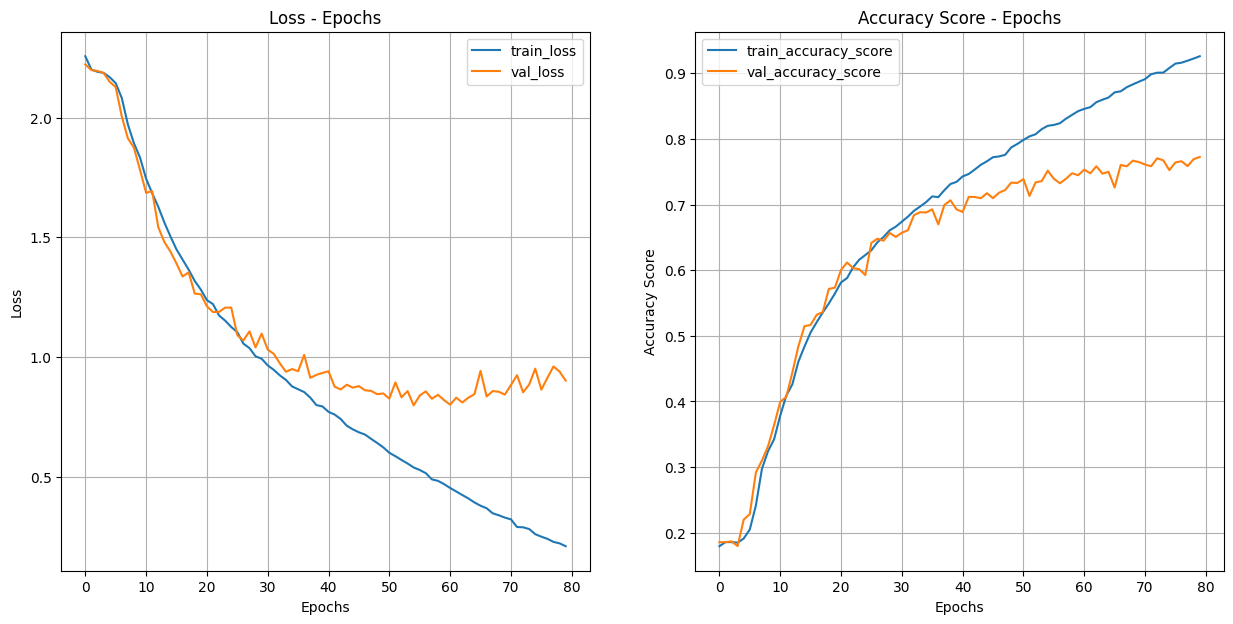

  0%|          | 0/121 [00:00<?, ?it/s]

Total evaluation time: 0.004 seconds

TEST Results for SingleResCNN-Stream_Type_None -> loss: 1.1801101398184772 accuracy-score: 0.7136585005903188


In [153]:
experiments_results.append(train_evaluate(CNN_arch_single, test_dl_single)) # Run train and evaluation

Image/s path:	test/PqGTLp6eLzo/bag_of_shots22
True label id:	269
True label name:	motorcycle racing

Top 3 Pred:	['karate\n', 'rugby\n', 'beach volleyball\n']
Top 3 Prob:	[0.999885082244873, 8.157524280250072e-05, 2.644246706040576e-05]


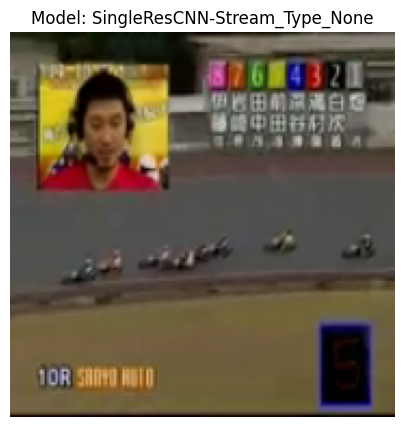

In [154]:
test_single_image(test_data_single, CNN_arch_single) # Test in a single random image

## Single Frame Model Fovea CNN

In [155]:
AN_Fovea = AlexNet(in_channels=3, stream_type='fovea') # Extractor
Fovea_CNN = SingleResCNN(AN_Fovea, num_classes=n_classes) # CNN model

optimizer_fovea = torch.optim.SGD(params=Fovea_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_fovea = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fovea, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_fovea = CNN_Architecture(model = Fovea_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_fovea,
             loss_fn = nn.CrossEntropyLoss(), #weight=weights
             score_fn = accuracy_score,
             scheduler = scheduler_fovea,
             device = device,
             patience = 15,
             save_check = True,
             load_check_train = False,
             load_check_evaluate = False)

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.254210, train_accuracy: 0.183406, val_loss: 2.222612, val_accuracy: 0.187681 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.206582, train_accuracy: 0.185658, val_loss: 2.201932, val_accuracy: 0.186987 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.195768, train_accuracy: 0.185658, val_loss: 2.200808, val_accuracy: 0.186987 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.193627, train_accuracy: 0.185658, val_loss: 2.198391, val_accuracy: 0.185598 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.193117, train_accuracy: 0.185658, val_loss: 2.197626, val_accuracy: 0.186292 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.193023, train_accuracy: 0.185658, val_loss: 2.197110, val_accuracy: 0.187681 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.192458, train_accuracy: 0.185658, val_loss: 2.197062, val_accuracy: 0.186987 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.191341, train_accuracy: 0.185953, val_loss: 2.194014, val_accuracy: 0.187681 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.190131, train_accuracy: 0.185658, val_loss: 2.192689, val_accuracy: 0.186292 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [10], train_loss: 2.179784, train_accuracy: 0.189752, val_loss: 2.169883, val_accuracy: 0.188345 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [11], train_loss: 2.137920, train_accuracy: 0.194778, val_loss: 2.111730, val_accuracy: 0.187409 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [12], train_loss: 2.104036, train_accuracy: 0.193186, val_loss: 2.073205, val_accuracy: 0.223551 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [13], train_loss: 2.069555, train_accuracy: 0.229667, val_loss: 2.041483, val_accuracy: 0.256673 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [14], train_loss: 2.033691, train_accuracy: 0.255163, val_loss: 1.993420, val_accuracy: 0.275574 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a c

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.994832, train_accuracy: 0.280704, val_loss: 1.936043, val_accuracy: 0.302748 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
if w.is_alive():    
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):

AssertionError  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
: can only test a child process
Exception ignored in:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProce

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.952984, train_accuracy: 0.299468, val_loss: 2.036642, val_accuracy: 0.278291 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in: <function _MultiProc

  0%|          | 0/115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [17], train_loss: 1.928237, train_accuracy: 0.305108, val_loss: 1.876340, val_accuracy: 0.314432 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

  0%|          | 0/115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [18], train_loss: 1.876067, train_accuracy: 0.315411, val_loss: 1.835913, val_accuracy: 0.318237 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'AssertionErrorException ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
can only test a child process    
self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     if w.is_alive():<

  0%|          | 0/115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch [19], train_loss: 1.830470, train_accuracy: 0.327579, val_loss: 1.897260, val_accuracy: 0.308877 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: self._shutdown_workers()can only test a child process
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():

Exception ignored in: 

  0%|          | 0/115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():
AssertionError  File "/usr/lib/python3.9/multiprocessing/process.py"

Epoch [20], train_loss: 1.803918, train_accuracy: 0.341089, val_loss: 1.791609, val_accuracy: 0.344233 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>Traceback (most recent call last):


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/

  0%|          | 0/115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>self._shutdown_workers()

  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    if w.is_alive():self._shutdown_workers()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'
    AssertionErrorif w.is_alive():
:   File "/usr/lib/python3.9/multiprocessing/process.p

Epoch [21], train_loss: 1.780904, train_accuracy: 0.350505, val_loss: 1.750637, val_accuracy: 0.361866 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3

  0%|          | 0/115 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()Exception ignored in: 
  File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f3b2988a280>    if w.is_alive():
  File "/usr/lib/python3.9/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'Traceback (most recent call last):

AssertionError:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
can only test a child process    
self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
<function _MultiProce

Epoch [22], train_loss: 1.747739, train_accuracy: 0.362787, val_loss: 1.776746, val_accuracy: 0.354680 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.725113, train_accuracy: 0.375136, val_loss: 1.671304, val_accuracy: 0.383726 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.671160, train_accuracy: 0.395242, val_loss: 1.640537, val_accuracy: 0.413919 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.645478, train_accuracy: 0.414347, val_loss: 1.597858, val_accuracy: 0.422222 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [26], train_loss: 1.599228, train_accuracy: 0.431905, val_loss: 1.552938, val_accuracy: 0.448702 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [27], train_loss: 1.554663, train_accuracy: 0.446211, val_loss: 1.529626, val_accuracy: 0.464493 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [28], train_loss: 1.527375, train_accuracy: 0.460176, val_loss: 1.557202, val_accuracy: 0.456431 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [29], train_loss: 1.490432, train_accuracy: 0.482828, val_loss: 1.521007, val_accuracy: 0.474064 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [30], train_loss: 1.465535, train_accuracy: 0.489083, val_loss: 1.572780, val_accuracy: 0.466908 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [31], train_loss: 1.449455, train_accuracy: 0.497976, val_loss: 1.457080, val_accuracy: 0.491455 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [32], train_loss: 1.427652, train_accuracy: 0.504685, val_loss: 1.409514, val_accuracy: 0.523460 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [33], train_loss: 1.382201, train_accuracy: 0.522698, val_loss: 1.678967, val_accuracy: 0.432005 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [34], train_loss: 1.370850, train_accuracy: 0.526815, val_loss: 1.470525, val_accuracy: 0.509964 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [35], train_loss: 1.346249, train_accuracy: 0.536709, val_loss: 1.406647, val_accuracy: 0.526570 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [36], train_loss: 1.314753, train_accuracy: 0.548399, val_loss: 1.437670, val_accuracy: 0.511111 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [37], train_loss: 1.282075, train_accuracy: 0.564456, val_loss: 1.354318, val_accuracy: 0.547494 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [38], train_loss: 1.256300, train_accuracy: 0.573690, val_loss: 1.406855, val_accuracy: 0.517421 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [39], train_loss: 1.235705, train_accuracy: 0.578967, val_loss: 1.383732, val_accuracy: 0.542331 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [40], train_loss: 1.196630, train_accuracy: 0.589611, val_loss: 1.247224, val_accuracy: 0.580133 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [41], train_loss: 1.182578, train_accuracy: 0.597935, val_loss: 1.352532, val_accuracy: 0.545984 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [42], train_loss: 1.152884, train_accuracy: 0.606373, val_loss: 1.304131, val_accuracy: 0.569414 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [43], train_loss: 1.132190, train_accuracy: 0.619155, val_loss: 1.242923, val_accuracy: 0.583092 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [44], train_loss: 1.105055, train_accuracy: 0.626092, val_loss: 1.338778, val_accuracy: 0.562711 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [45], train_loss: 1.086855, train_accuracy: 0.633097, val_loss: 1.197588, val_accuracy: 0.597796 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [46], train_loss: 1.063144, train_accuracy: 0.643059, val_loss: 1.253031, val_accuracy: 0.587047 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [47], train_loss: 1.033631, train_accuracy: 0.651724, val_loss: 1.272859, val_accuracy: 0.576963 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [48], train_loss: 1.010494, train_accuracy: 0.661913, val_loss: 1.250472, val_accuracy: 0.597645 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.988964, train_accuracy: 0.667167, val_loss: 1.281110, val_accuracy: 0.574940 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.969172, train_accuracy: 0.671716, val_loss: 1.285188, val_accuracy: 0.578170 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.952570, train_accuracy: 0.680586, val_loss: 1.244090, val_accuracy: 0.594656 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.928908, train_accuracy: 0.686840, val_loss: 1.157829, val_accuracy: 0.624970 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.907939, train_accuracy: 0.696666, val_loss: 1.175900, val_accuracy: 0.622101 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.887326, train_accuracy: 0.702329, val_loss: 1.238819, val_accuracy: 0.597917 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.858464, train_accuracy: 0.712473, val_loss: 1.227592, val_accuracy: 0.618146 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.842407, train_accuracy: 0.717090, val_loss: 1.240055, val_accuracy: 0.617331 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.802396, train_accuracy: 0.730941, val_loss: 1.221434, val_accuracy: 0.621014 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.794208, train_accuracy: 0.737150, val_loss: 1.416472, val_accuracy: 0.569958 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.769606, train_accuracy: 0.736877, val_loss: 1.232606, val_accuracy: 0.629589 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [60], train_loss: 0.756450, train_accuracy: 0.743450, val_loss: 1.210064, val_accuracy: 0.625604 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [61], train_loss: 0.738791, train_accuracy: 0.752957, val_loss: 1.297210, val_accuracy: 0.602536 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [62], train_loss: 0.720343, train_accuracy: 0.759825, val_loss: 1.306891, val_accuracy: 0.609571 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [63], train_loss: 0.665491, train_accuracy: 0.777520, val_loss: 1.383311, val_accuracy: 0.603774 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [64], train_loss: 0.666309, train_accuracy: 0.775814, val_loss: 1.301022, val_accuracy: 0.620622 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [65], train_loss: 0.644403, train_accuracy: 0.782478, val_loss: 1.291951, val_accuracy: 0.622947 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [66], train_loss: 0.613412, train_accuracy: 0.796852, val_loss: 1.328876, val_accuracy: 0.627566 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [67], train_loss: 0.591592, train_accuracy: 0.800264, val_loss: 1.359264, val_accuracy: 0.621558 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [68], train_loss: 0.574530, train_accuracy: 0.807906, val_loss: 1.323599, val_accuracy: 0.627808 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [69], train_loss: 0.544039, train_accuracy: 0.818846, val_loss: 1.403326, val_accuracy: 0.627415 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [70], train_loss: 0.530775, train_accuracy: 0.823394, val_loss: 1.345496, val_accuracy: 0.629046 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [71], train_loss: 0.523052, train_accuracy: 0.824395, val_loss: 1.320914, val_accuracy: 0.625574 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [72], train_loss: 0.485582, train_accuracy: 0.838792, val_loss: 1.620760, val_accuracy: 0.591093 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [73], train_loss: 0.475274, train_accuracy: 0.840771, val_loss: 1.384120, val_accuracy: 0.639342 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [74], train_loss: 0.474400, train_accuracy: 0.842249, val_loss: 1.445853, val_accuracy: 0.615972 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [75], train_loss: 0.451573, train_accuracy: 0.849618, val_loss: 1.404138, val_accuracy: 0.634722 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [76], train_loss: 0.411048, train_accuracy: 0.866130, val_loss: 1.513215, val_accuracy: 0.611353 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [77], train_loss: 0.404591, train_accuracy: 0.862127, val_loss: 1.665045, val_accuracy: 0.626178 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [78], train_loss: 0.417463, train_accuracy: 0.860126, val_loss: 1.518317, val_accuracy: 0.640308 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [79], train_loss: 0.358631, train_accuracy: 0.881732, val_loss: 1.641481, val_accuracy: 0.634481 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [80], train_loss: 0.342160, train_accuracy: 0.886099, val_loss: 1.631999, val_accuracy: 0.621920 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE

Total training time: 1.594 seconds


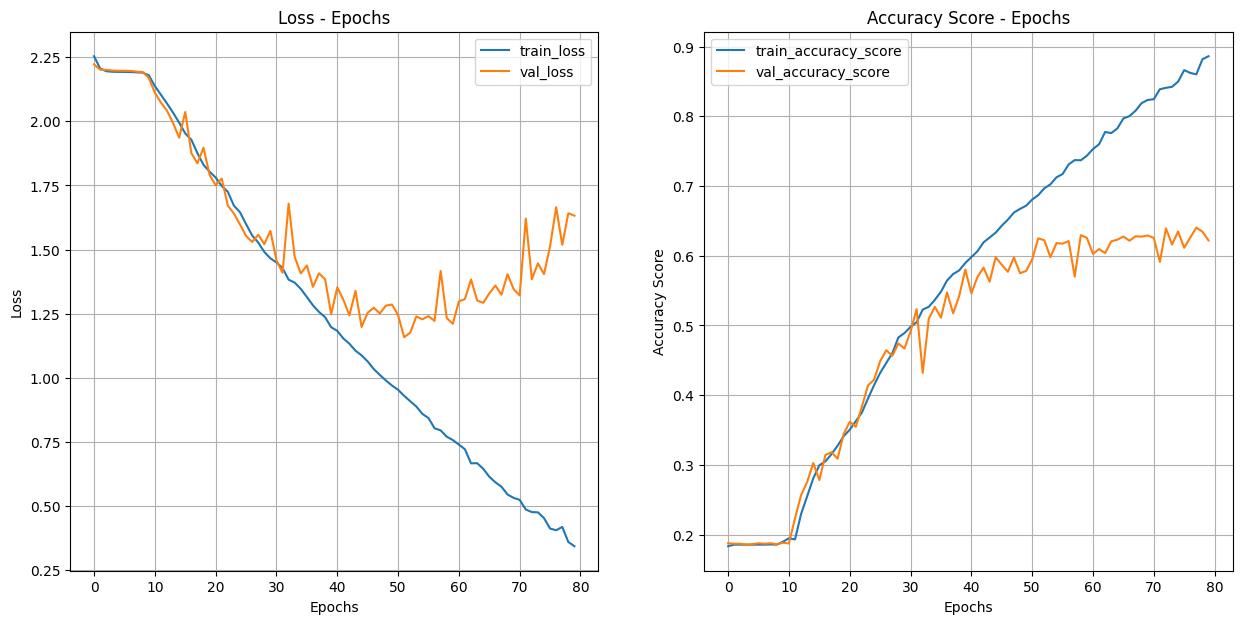

  0%|          | 0/121 [00:00<?, ?it/s]

Total evaluation time: 0.005 seconds

TEST Results for SingleResCNN-Stream_Type_fovea -> loss: 1.8432310553621654 accuracy-score: 0.5877730224321133


In [156]:
experiments_results.append(train_evaluate(CNN_arch_fovea, test_dl_single)) # Run train and evaluation

Image/s path:	test/EbdiITWYmZg/bag_of_shots5
True label id:	361
True label name:	beach volleyball

Top 3 Pred:	['motorcycle racing\n', 'karate\n', 'basketball\n']
Top 3 Prob:	[0.9854550361633301, 0.014502514153718948, 1.7532860510982573e-05]


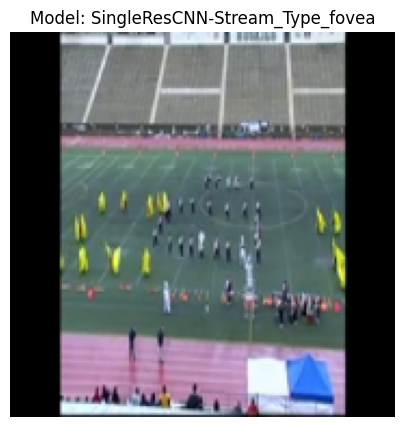

In [157]:
test_single_image(test_data_single, CNN_arch_fovea) # Test in a single random image

## Single Frame Model Context CNN

In [158]:
AN_Context = AlexNet(in_channels=3, stream_type='context') # Extractor
Context_CNN = SingleResCNN(AN_Context, num_classes=n_classes) # CNN model

optimizer_context = torch.optim.SGD(params=Context_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_context = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_context, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_context = CNN_Architecture(model = Context_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_context,
             loss_fn = nn.CrossEntropyLoss(), #weight=weights
             score_fn = accuracy_score,
             scheduler = scheduler_context,
             device = device,
             patience = 15,
             save_check = True,
             load_check_train = False,
             load_check_evaluate = False)

In [159]:
experiments_results.append(train_evaluate(CNN_arch_context, test_dl_single)) # Run train and evaluation

  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.256105, train_accuracy: 0.178994, val_loss: 2.223663, val_accuracy: 0.187681 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.207041, train_accuracy: 0.186545, val_loss: 2.201701, val_accuracy: 0.187681 

=> Saving Checkpoint to last_checkpoints
 DONE

=> Saving Checkpoint to best_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.195465, train_accuracy: 0.185953, val_loss: 2.197739, val_accuracy: 0.186292 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.193519, train_accuracy: 0.186249, val_loss: 2.197954, val_accuracy: 0.185598 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.193160, train_accuracy: 0.186249, val_loss: 2.198102, val_accuracy: 0.185598 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.192958, train_accuracy: 0.185953, val_loss: 2.198362, val_accuracy: 0.185598 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.192896, train_accuracy: 0.185953, val_loss: 2.197817, val_accuracy: 0.186987 

=> Saving Checkpoint to last_checkpoints
 DONE



  0%|          | 0/458 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
test_single_image(test_data_single, CNN_arch_context) # Test in a single random image

## Single Frame Model Multiresolution CNN

In [ ]:
AN_Multi_Fovea, AN_Multi_context = AlexNet(in_channels=3, stream_type='fovea'), AlexNet(in_channels=3, stream_type='context') # Extractors
Multi_CNN = MultiResCNN(AN_Multi_Fovea, AN_Multi_context, num_classes=n_classes) # CNN model

optimizer_multi = torch.optim.SGD(params=Multi_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_multi = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_multi, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_multi = CNN_Architecture(model = Multi_CNN, 
             train_dataloader = train_dl_single,
             val_dataloader = val_dl_single,
             optimizer = optimizer_multi,
             loss_fn = nn.CrossEntropyLoss(), #weight=weights
             score_fn = accuracy_score,
             scheduler = scheduler_multi,
             device = device,
             patience = 15,
             save_check = True,
             load_check_train = False,
             load_check_evaluate = False)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_multi, test_dl_single)) # Run train and evaluation

In [ ]:
test_single_image(test_data_single, CNN_arch_multi) # Test in a single random image

## Multi Frame Model Late Fusion CNN

In [ ]:
AN_Late1, AN_late2 = AlexNet(in_channels=3), AlexNet(in_channels=3) # Extractors
Late_CNN = LateFusionCNN(AN_Late1, AN_late2, num_classes=n_classes) # CNN model

optimizer_late = torch.optim.SGD(params=Late_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_late = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_late, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_late = CNN_Architecture(model = Late_CNN, 
             train_dataloader = train_dl_late,
             val_dataloader = val_dl_late,
             optimizer = optimizer_late,
             loss_fn = nn.CrossEntropyLoss(), #weight=weights
             score_fn = accuracy_score,
             scheduler = scheduler_late,
             device = device,
             patience = 15,
             save_check = True,
             load_check_train = False,
             load_check_evaluate = False)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_late, test_dl_late)) # Run train and evaluation

In [ ]:
test_single_image(test_data_late, CNN_arch_late) # Test in a single random image

## Multi Frame Model Early Fusion CNN

In [ ]:
AN_Early = AlexNet(in_channels=3, t_frames=[5,1,1]) # Extractor
Early_CNN = EarlyFusionCNN(AN_Early, num_classes=n_classes) # CNN model

optimizer_early = torch.optim.SGD(params=Early_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_early = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_early, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_early = CNN_Architecture(model = Early_CNN, 
             train_dataloader = train_dl_early,
             val_dataloader = val_dl_early,
             optimizer = optimizer_early,
             loss_fn = nn.CrossEntropyLoss(), #weight=weights
             score_fn = accuracy_score,
             scheduler = scheduler_early,
             device = device,
             patience = 15,
             save_check = True,
             load_check_train = False,
             load_check_evaluate = False)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_early, test_dl_early)) # Run train and evaluation

In [ ]:
test_single_image(test_data_early, CNN_arch_early) # Test in a single random image

## Multi Frame Model Slow Fusion CNN

In [ ]:
AN_Slow = AlexNet(in_channels=3, t_frames=[4,2,2]) # Extractor
Slow_CNN = SlowFusionCNN(AN_Slow, num_classes=n_classes) # CNN model

optimizer_slow = torch.optim.SGD(params=Slow_CNN.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-5) # Optimizer 
scheduler_slow = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_slow, factor=0.1, patience=2, verbose=True) # Scheduler

# Architecture definition
CNN_arch_slow = CNN_Architecture(model = Slow_CNN, 
             train_dataloader = train_dl_slow,
             val_dataloader = val_dl_slow,
             optimizer = optimizer_slow,
             loss_fn = nn.CrossEntropyLoss(), #weight=weights
             score_fn = accuracy_score,
             scheduler = scheduler_slow,
             device = device,
             patience = 15,
             save_check = True,
             load_check_train = False,
             load_check_evaluate = False)

In [ ]:
experiments_results.append(train_evaluate(CNN_arch_slow, test_dl_slow)) # Run train and evaluation

In [ ]:
test_single_image(test_data_slow, CNN_arch_slow) # Test in a single random image

## Result Summary

Summary Widget with all the previous loss & score plot

In [ ]:
if (len(experiments_results) > 0):
    tb = widgets.TabBar([exp[0]['model_name'] for exp in experiments_results])

    for idx, exp in enumerate(experiments_results):
        history, _, _, _ = exp
        with tb.output_to(history['model_name'], select=(idx == 0)):
            plot_loss_curves(history)

Summary of test results

In [ ]:
if (len(experiments_results) > 0):
    test_results_grid = widgets.Grid(len(experiments_results) + 1, 3, header_row=True)

    with test_results_grid.output_to(0, 0): print('Model Name')
    with test_results_grid.output_to(0, 1): print('Test Loss')
    with test_results_grid.output_to(0, 2): print('Test Accuracy Score')
    with test_results_grid.output_to(0, 3): print('Testing Time in hours')
    with test_results_grid.output_to(0, 4): print('Training Time in hours')

    for row, exp in enumerate(experiments_results):
        _, results, test_t, train_t = exp
        for col, val in enumerate(results.values()):
            with test_results_grid.output_to(row + 1, col): print(val)
        with test_results_grid.output_to(row + 1, 3): print(test_t)
        with test_results_grid.output_to(row + 1, 4): print(train_t)